<a href="https://colab.research.google.com/github/snowshine/NFTCreators/blob/main/gan/gan_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect to google drive for data
Assumed structue:
- original dataset: [current directory]/data/[collection name].npz
- pre-trained model: [current directory]/output/[collection name]
- loss records during training: [current directory]/output/[collection name]/train_loss.pkl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# change working directory
%cd /content/drive/MyDrive/capstone/
!ls -art

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/capstone
output	generator  0100.png  data


### IS and FID calculation
Reference: 
- machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/
- machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

In [ ]:
import numpy as np
from numpy.random import shuffle
from math import floor
from scipy.linalg import sqrtm
from skimage.transform import resize
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Sequential, Model, load_model

# load the inception v3 model
# model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
model = InceptionV3()

# calculate inception score
def calculate_inception_score(model, images, n_split=10, eps=1E-16):
	if images.shape[0] < n_split:
			n_split = images.shape[0]			
	n_part = floor(images.shape[0] / n_split)

	# enumerate splits of images/predictions
	scores = list()
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = np.expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = np.mean(sum_kl_d)
		# undo the log
		is_score = np.exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = np.mean(scores), np.std(scores)
	return is_avg, is_std
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def prepare_inception_images(images):
		# convert from uint8 to float32
		images = images.astype('float32')
		# scale images to the required size
		images = scale_images(images, (299,299,3))
		# pre-process images, scale to [-1,1]
		images = preprocess_input(images)
		return images

def evaluate_epoch(collection, batch_size, epoch, view_img_square):
  # get both original and generated images
  images_orig, images_gen = get_images(collection, batch_size, epoch, view_img_square)

  # calculate inception score for both original and generated images
  o_is_avg, o_is_std = calculate_inception_score(model, images_orig)  
  g_is_avg, g_is_std = calculate_inception_score(model, images_gen)

  # calculate fid
  fid = calculate_fid(model, images_gen, images_orig)
  
  return o_is_avg, o_is_std, g_is_avg, g_is_std, fid

def get_images(collection, batch_size, epoch, view_img_square=2):
	images_orig = load_origin_images(collection, batch_size)
	images_gen = load_generated_images(collection, batch_size, epoch)
	# print('loaded:', images_orig.shape, images_gen.shape)

	view_generated_images(images_gen, view_img_square)
 
	shuffle(images_orig)
	shuffle(images_gen)
 
	images_orig = prepare_inception_images(images_orig)
	images_gen = prepare_inception_images(images_gen)
	# print('prepared:', images_orig.shape, images_gen.shape)
 
	return images_orig, images_gen

# load original images used for training
def load_origin_images(collection, batch_size):
  np_data = np.load('data/' + collection + '.npz')['arr_0'][:batch_size]
  return np_data

# use generator to generate images
def load_generated_images(collection, batch_size, epoch):
  gen_path = 'output/' + collection + "/generator" + str(epoch)
  generator = load_model(gen_path, compile=False)
  generator.compile(optimizer='adam', loss='binary_crossentropy')
 
  SEED_DIM = 100  # Size vector to generate images from
  noise = tf.random.normal([batch_size, SEED_DIM])
  generated_image = generator(noise, training=False)
  
  return generated_image.numpy()

def view_generated_images(imgs, n):
  # scale generated image from [-1,1] to [0,1]
	imgs = (imgs + 1) / 2.0
	imgs = imgs.astype('float32')
	
	fig = plt.figure(figsize=(6, 6))
	for i in range(n * n):		
		plt.subplot(n, n, 1 + i)		
		plt.axis('off')
		# plot raw pixel data
		if (i + 1)%2 == 0:			
	 		plt.imshow(imgs[i, :, :, 0], cmap='gray')
		else:			
	 		plt.imshow(imgs[i])
	
	plt.show()

# load and show training loss metrics, either at batch or epoch level
def loss_metrics_chart(collection, whichchart):  
	df = pd.read_pickle('output/' + collection + '/train_loss.pkl')
	
	if whichchart == 'epoch': # group by epoch
		df = df.groupby('epoch').mean()
		xlabel = 'training run at epoch level'
		fsize = [12, 10]
	else:
		xlabel = 'training run at batch level'
		fsize = [18, 12]
  
	fig, ax = plt.subplots(figsize=fsize)	

	plt.plot(df.index, df["g_loss"], label='generator loss')
	plt.plot(df.index, df["d_loss"], label='discriminator loss')
	plt.plot(df.index, df["g_loss"]+df["d_loss"], label='total loss')

	ax.set_xlabel(xlabel)
	# ax.set_ylabel('loss')
  
	plt.title("Generator and Discriminator Loss During Training")
	plt.legend()
	plt.show()

### Test using Cifar10 dataset

Output:
- Loaded (2000, 32, 32, 3) (2000, 32, 32, 3)
- prepared: (2000, 299, 299, 3) (2000, 299, 299, 3)
- IS score for train images 10.334155  with std  0.5321305
- IS score for test images 9.905649  with std  0.6153645

In [ ]:
# from keras.datasets.mnist import load_data
from keras.datasets import cifar10

def get_prepared_cifar10(batch_size):
  # calculate inception score for cifar-10 in Keras
  # load cifar10 images
  (images_train, _), (images_test, _) = cifar10.load_data()
  shuffle(images_train)
  # images1 = images1[:10000]
  images_train = images_train[:batch_size]
  images_test = images_test[:batch_size]
  print('Loaded', images_train.shape, images_test.shape)

  images_train = prepare_inception_images(images_train)
  images_test = prepare_inception_images(images_test)
  print('prepared:', images_train.shape, images_test.shape)

  return images_train, images_test

batch_size = 2000
images_orig, images_gen = get_prepared_cifar10(batch_size)

# calculate inception score
is_avg, is_std = calculate_inception_score(model, images_orig)
print('IS score for train images', is_avg, ' with std ', is_std)

is_avg, is_std = calculate_inception_score(model, images_gen)
print('IS score for test images', is_avg, ' with std ', is_std)

# calculate fid
fid = calculate_fid(model, images_gen, images_orig)
print('FID: %.3f' % fid)

Loaded (2000, 32, 32, 3) (2000, 32, 32, 3)
prepared: (2000, 299, 299, 3) (2000, 299, 299, 3)
IS score for train images 9.86476  with std  0.65056324
IS score for test images 9.905661  with std  0.6153251
FID: 0.028


### Saved Results for Collections

meebits
- loaded: (200, 128, 128, 3) (200, 128, 128, 3)
- prepared: (200, 299, 299, 3) (200, 299, 299, 3)
- IS score for original images 1.0484111 with std 0.011174799
- IS score for generated images 1.0297205 with std 0.015230436
- FID: 0.001

cryptopunks32
- loaded: (1000, 32, 32, 3) (1000, 32, 32, 3)
- prepared: (1000, 299, 299, 3) (1000, 299, 299, 3)
- IS score for original images 1.0042558 with std 0.00033540194
- IS score for generated images 1.0043802 with std 0.0002382655
- FID: 0.000

hapeprime32
- loaded: (2000, 32, 32, 3) (2000, 32, 32, 3)
- prepared: (2000, 299, 299, 3) (2000, 299, 299, 3)
- IS score for original images 1.0213796 with std 0.0020361624
- IS score for generated images 1.0164949 with std 0.0014360597
- FID: 0.000

apes (combined-apes)
- loaded: (200, 128, 128, 3) (200, 128, 128, 3)
- prepared: (200, 299, 299, 3) (200, 299, 299, 3)
- IS score for original images 1.066714  with std  0.014968084
- IS score for generated images 1.0243697  with std  0.0038336152
- FID: 0.007

### Evaluations

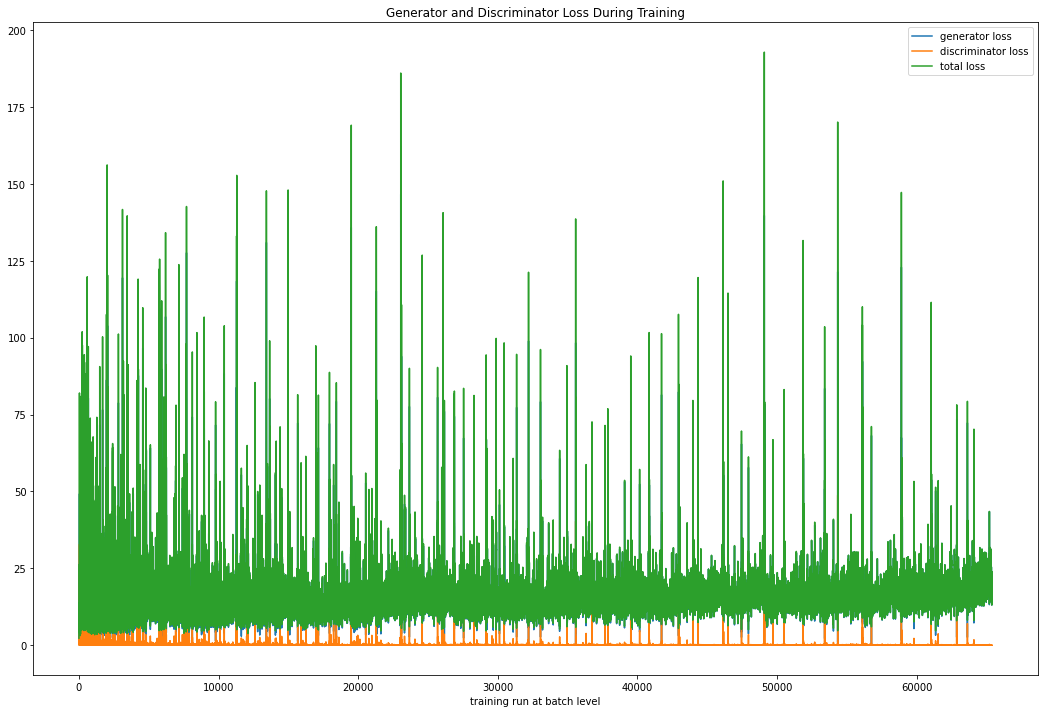

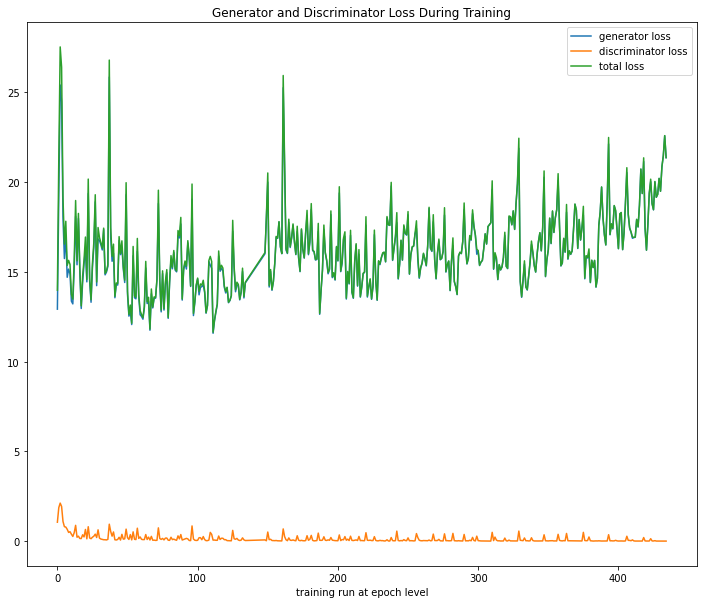

In [ ]:
collection = "meebits"

# display training loss metrics, both batch and epoch level
loss_metrics_chart(collection, 'batch')
loss_metrics_chart(collection, 'epoch')

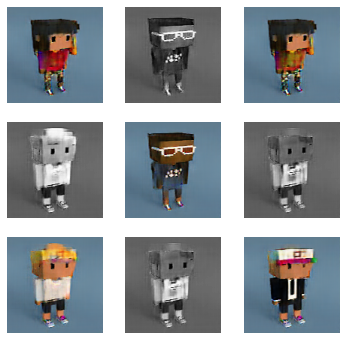

Collection: meebits  at epoch  404
IS score for original images 1.0494361  with std  0.011777517
IS score for generated images 1.0267513  with std  0.0035677447
FID: 0.001


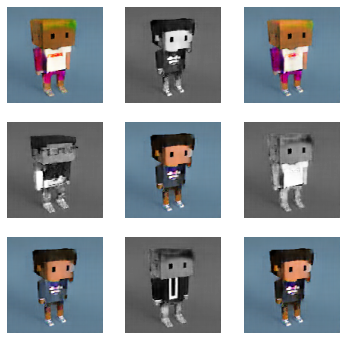

Collection: meebits  at epoch  389
IS score for original images 1.048119  with std  0.010776272
IS score for generated images 1.0306779  with std  0.009682641
FID: 0.001


In [ ]:
batch_size = 200
view_img_square = 3 # generated samples to view in square, i.e 3x3=9
# generator_epoch = [480, 465,450,435,420,390,375,360,345,330,315,300,285,270,255,240,225,210]
# generator_epoch = [434,419,404,389,374,359,344,329,314,299,284,269, 254,239,224, 209,194, 179, 164,149, 134,119,104,89,74,59]
# generator_epoch = [270,255,210,195,180,135, 120]
generator_epoch = [404,389]

# manual evaluation of generated images as well as IS and FID scores
for epoch in generator_epoch:  
  o_is_avg, o_is_std, g_is_avg, g_is_std, fid = evaluate_epoch(collection, batch_size, epoch, view_img_square)
  print('Collection:', collection, ' at epoch ', epoch)
  print('IS score for original images', o_is_avg, ' with std ', o_is_std)
  print('IS score for generated images', g_is_avg, ' with std ', g_is_std)
  print('FID: %.3f' % fid)